## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

In [6]:
#!gdown 16kbVAyPoIgeXEYf6egRt2GyEm96auqeu
#!mkdir data
#!unzip forest_fire.zip -d data

In [13]:
import pathlib
data_dir = pathlib.Path('data/forest_fire')
image_count = len(list(data_dir.glob('**/*.jpg')))
print(image_count)

1933


Fire:

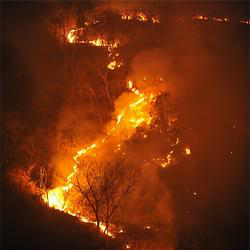

In [40]:
training_dir = pathlib.Path(str(data_dir)+"/Training")
testing_dir = pathlib.Path(str(data_dir)+"/Testing")
fires = list(training_dir.glob('fire/*'))
PIL.Image.open(str(fires[0]))

NoFire:

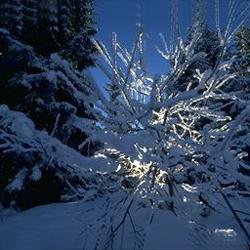

In [16]:
nofires = list(training_dir.glob('nofire/*'))
PIL.Image.open(str(nofires[0]))

# Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

## Create a dataset

Define some parameters for the loader:

In [17]:
batch_size = 32
img_height = 250
img_width = 250

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [18]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  training_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1865 files belonging to 2 classes.
Using 1492 files for training.


In [19]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  training_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1865 files belonging to 2 classes.
Using 373 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [20]:
class_names = train_ds.class_names
print(class_names)

['fire', 'nofire']


## Visualize the data

Here are the first nine images from the training dataset:

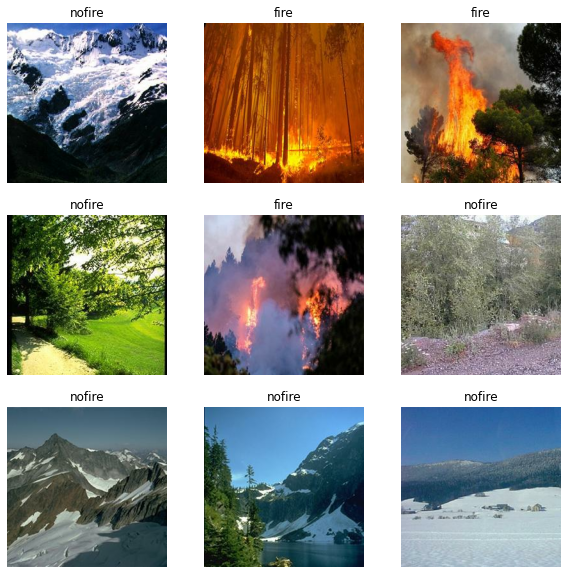

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `Model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [22]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 250, 250, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [24]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [25]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

# Create the model

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

In [26]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `Model.summary` method:

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        1

## Train the model

In [29]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
47/47 [==============================] - 13s 41ms/step - loss: 0.4132 - accuracy: 0.8559 - val_loss: 0.1729 - val_accuracy: 0.9544
Epoch 2/10
47/47 [==============================] - 1s 27ms/step - loss: 0.1643 - accuracy: 0.9383 - val_loss: 0.1117 - val_accuracy: 0.9732
Epoch 3/10
47/47 [==============================] - 1s 27ms/step - loss: 0.1598 - accuracy: 0.9484 - val_loss: 0.0928 - val_accuracy: 0.9678
Epoch 4/10
47/47 [==============================] - 1s 27ms/step - loss: 0.1263 - accuracy: 0.9551 - val_loss: 0.0878 - val_accuracy: 0.9732
Epoch 5/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0846 - accuracy: 0.9732 - val_loss: 0.0864 - val_accuracy: 0.9732
Epoch 6/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0582 - accuracy: 0.9812 - val_loss: 0.1590 - val_accuracy: 0.9249
Epoch 7/10
47/47 [==============================] - 1s 27ms/step - loss: 0.0633 - accuracy: 0.9759 - val_loss: 0.1111 - val_accuracy: 0.9625
Epoch 8/10
4

## Visualize training results

Create plots of loss and accuracy on the training and validation sets:

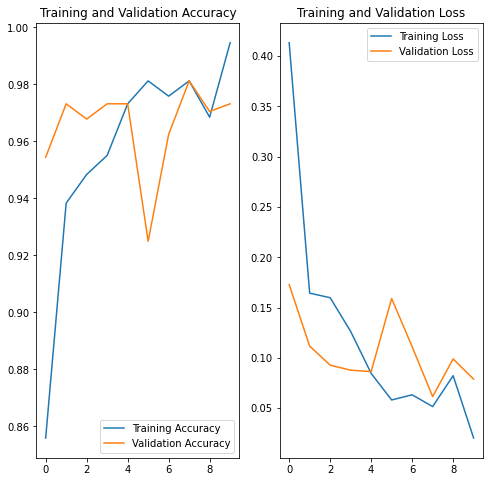

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

Let's inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [31]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

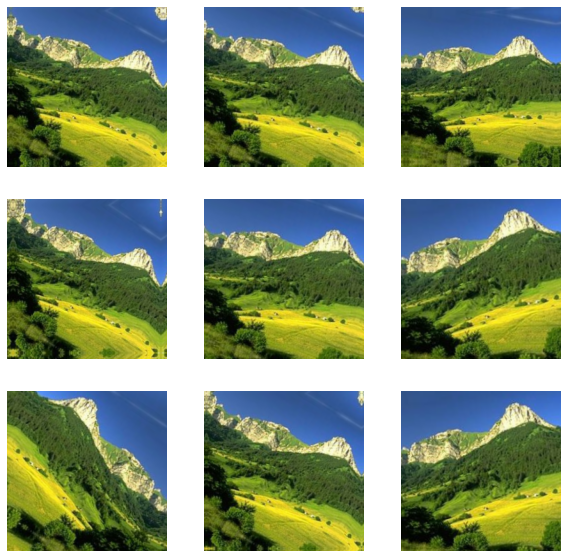

In [32]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [33]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 250, 250, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 125, 125, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                  

In [36]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
47/47 [==============================] - 3s 34ms/step - loss: 0.4549 - accuracy: 0.8385 - val_loss: 0.1679 - val_accuracy: 0.9491
Epoch 2/15
47/47 [==============================] - 1s 32ms/step - loss: 0.2313 - accuracy: 0.9122 - val_loss: 0.1858 - val_accuracy: 0.9303
Epoch 3/15
47/47 [==============================] - 1s 32ms/step - loss: 0.1691 - accuracy: 0.9383 - val_loss: 0.1053 - val_accuracy: 0.9571
Epoch 4/15
47/47 [==============================] - 1s 32ms/step - loss: 0.1661 - accuracy: 0.9410 - val_loss: 0.1325 - val_accuracy: 0.9625
Epoch 5/15
47/47 [==============================] - 1s 32ms/step - loss: 0.1415 - accuracy: 0.9491 - val_loss: 0.1114 - val_accuracy: 0.9705
Epoch 6/15
47/47 [==============================] - 1s 32ms/step - loss: 0.1241 - accuracy: 0.9511 - val_loss: 0.1086 - val_accuracy: 0.9732
Epoch 7/15
47/47 [==============================] - 2s 32ms/step - loss: 0.1109 - accuracy: 0.9618 - val_loss: 0.0904 - val_accuracy: 0.9732
Epoch 8/15
47

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

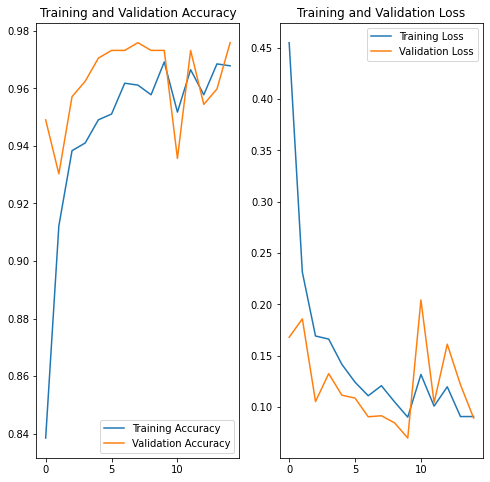

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [79]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving no-fire1.jpg to no-fire1.jpg
User uploaded file "no-fire1.jpg" with length 48276 bytes


In [80]:
# sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
# sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
filename = list(uploaded.keys())[0]

img = tf.keras.utils.load_img(
    filename, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to fire with a 100.00 percent confidence.


###Evaluate Model

In [41]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  testing_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size, shuffle=True)

results_eval = model.evaluate(test_ds, batch_size=batch_size)
print(results_eval)

Found 68 files belonging to 2 classes.
3/3 [==============================] - 0s 46ms/step - loss: 0.3931 - accuracy: 0.9265
[0.3930993974208832, 0.9264705777168274]


###FineTune Model

In [45]:
batch_size = 32
img_height = 224
img_width = 224

In [46]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  training_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1865 files belonging to 2 classes.
Using 1492 files for training.


In [47]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  training_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1865 files belonging to 2 classes.
Using 373 files for validation.


In [48]:
IMG_SIZE  = (img_height, img_width)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

(224, 224)


In [49]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [51]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [52]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [53]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [58]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [59]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [60]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

### Train Model

In [61]:
initial_epochs = 25

loss0, accuracy0 = model.evaluate(val_ds)

12/12 [==============================] - 4s 64ms/step - loss: 1.0458 - accuracy: 0.2413


In [64]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
47/47 [==============================] - 3s 58ms/step - loss: 0.1072 - accuracy: 0.9698 - val_loss: 0.0940 - val_accuracy: 0.9812
Epoch 2/10
47/47 [==============================] - 3s 58ms/step - loss: 0.1017 - accuracy: 0.9806 - val_loss: 0.0902 - val_accuracy: 0.9812
Epoch 3/10
47/47 [==============================] - 3s 58ms/step - loss: 0.0980 - accuracy: 0.9745 - val_loss: 0.0869 - val_accuracy: 0.9812
Epoch 4/10
47/47 [==============================] - 5s 89ms/step - loss: 0.0904 - accuracy: 0.9772 - val_loss: 0.0834 - val_accuracy: 0.9812
Epoch 5/10
47/47 [==============================] - 3s 58ms/step - loss: 0.0911 - accuracy: 0.9759 - val_loss: 0.0807 - val_accuracy: 0.9812
Epoch 6/10
47/47 [==============================] - 3s 58ms/step - loss: 0.0871 - accuracy: 0.9759 - val_loss: 0.0780 - val_accuracy: 0.9812
Epoch 7/10
47/47 [==============================] - 4s 80ms/step - loss: 0.0796 - accuracy: 0.9786 - val_loss: 0.0759 - val_accuracy: 0.9812
Epoch 8/10
47

### Evaluate Model

In [81]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  testing_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size, shuffle=True)

results_eval = model.evaluate(test_ds, batch_size=batch_size)
print(results_eval)

Found 68 files belonging to 2 classes.
3/3 [==============================] - 0s 79ms/step - loss: 0.0898 - accuracy: 1.0000
[0.08978696167469025, 1.0]


### Save Model

In [82]:
model.save('best_model.h5')